# AI DEMO - Summit -Tensorflow Dance Move Training

This note book should be able to run on the OCP4 Demo Cluster by simply selecting "Cell" and then "Run All" at the top of the page.

Running this notebook will:
* Pull gesture data from S3
* Preprocess the gesture data
* Train a Tensorflow neural network model
* Save the model for serving

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import s3fs
import scipy.stats
import pandas as pd
import numpy as np
import scipy
from pathlib import Path
from datetime import datetime as dt
import matplotlib.pylab as plt
import json
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras

Functions to read and preprocess raw data from Open Data Hub

In [3]:
def get_raw_data(fs, path, debug=False):
    '''Reads raw data from S3 - not parallelized
    '''
    data = {}
    
    gestures_paths = fs.ls(path)
    
    for gesture in gestures_paths:
        files_to_read = fs.ls(gesture)
    
        key = gesture.split('/')[-1] 
        data[key] = []
        if debug:
            print(key)
    
        for file in files_to_read:
            with fs.open(file) as f:
                content = json.loads(f.read())
            data[key].append(content)
    
    return data

counter = 0
def process_crosses_data(data_crosses):
    '''Returns list of size N_samples and each element = tuple(index, label, acc+rot vel dataframe, rot angle dataframe)
    '''

    global counter
    
    data_cross_list = []
    gesture = 'draw-cross'

    for d in data_crosses: #loop over each sample
        acc_data = pd.DataFrame([x['acceleration'] for elem in data_crosses[d] for x in elem['motion']])
        acc_data.columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']

        rot_data = pd.DataFrame([x['rotationRate'] for elem in data_crosses[d] for x in elem['motion']])
        rot_data.columns = ['rotation_alpha', 'rotation_beta', 'rotation_gamma']

        timestamp_data = pd.DataFrame([x['timestamp'] for elem in data_crosses[d] for x in elem['motion']])
        timestamp_data.columns = ['timestamp']

        motion_df = pd.concat([acc_data, rot_data, timestamp_data], axis=1).sort_values('timestamp', ascending=True).drop('timestamp', axis=1)
        orientation_df = None

        data_cross_list.append((counter, gesture, motion_df, orientation_df))
        counter += 1
        
    return data_cross_list

def process_dance_data(data_dance_raw):
    '''Returns list of size N_samples and each element = tuple(index, label, acc+rot vel dataframe, rot angle dataframe)
    '''

    #Ugly
    #convert appropriate data to dataframes
    global counter
    
    data = []
    #counter = 0 #counter from before
    for k in data_dance_raw.keys(): #loop over each dance type
        d = data_dance_raw[k]
        for example in d: #loop over each sample
            gesture = example['gesture']

            motion = np.array(example['motion'])
            orientation = np.array(example['orientation'])

            #process motion data
            if len(motion)>0:
                if motion.shape[1]==7: #incl. acc and rotational velocities
                    motion_df = pd.DataFrame(motion, columns=['acceleration_x', 'acceleration_y', 'acceleration_z',
                                                             'rotation_alpha', 'rotation_beta', 'rotation_gamma',
                                                              'timestamp'
                                                             ])\
                                    .sort_values('timestamp', ascending=True)\
                                    .drop('timestamp', axis=1)
                
                elif motion.shape[1]==4: #incl. acc only
                    motion_df = pd.DataFrame(motion, columns=['acceleration_x', 'acceleration_y', 'acceleration_z',
                                                              'timestamp'
                                                             ])\
                                    .sort_values('timestamp', ascending=True)\
                                    .drop('timestamp', axis=1)

                else: #shouldn't enter
                    motion_df = pd.DataFrame()
            else: #no motion data recorded
                motion_df = pd.DataFrame()


            #process orientation data
            if len(orientation) > 0:
                orientation_df = pd.DataFrame(orientation, columns=['alpha', 'beta', 'gamma', 'timestamp'])\
                                        .sort_values('timestamp', ascending=True)\
                                        .drop('timestamp', axis=1)
            else:
                orientation_df = pd.DataFrame()

            data.append((counter, gesture, motion_df, orientation_df))

            counter += 1
    
    return data

#### Read raw dance and crosses data

In [ ]:
fs = s3fs.S3FileSystem()

In [ ]:
path_to_dance_data = 'cchase-rh-demo-4/training-data'
path_to_cross_data = 'cchase-rh-demo-4/mock-server-data/motions/2019-02-26'

In [ ]:
data_dance_raw = get_raw_data(fs, path_to_dance_data, debug=False)
data_cross_raw = get_raw_data(fs, path_to_cross_data, debug=False)

In [5]:
counter = 0
data_dance_proc = process_dance_data(data_dance_raw)
data_cross_proc = process_crosses_data(data_cross_raw)

In [6]:
del data_dance_raw
del data_cross_raw

In [7]:
data = data_dance_proc + data_cross_proc

In [8]:
del data_dance_proc
del data_cross_proc

In [9]:
data = [d for d in data if d[2].shape[1]==6 and d[2].shape[0]>50] # <---- clean data

In [10]:
np.unique([d[1] for d in data], return_counts=True)

(array(['draw-circle', 'draw-cross', 'draw-triangle', 'fever', 'floss',
        'roll', 'shake'], dtype='<U13'),
 array([121, 185, 128, 123, 110, 137, 136]))

In [11]:
def featurize(ts, bins, TAG):
    '''Take time-series and create features
    '''
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b = np.histogram(ts, bins=bins)
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    if median == 0: 
        features = {f'{TAG}_mean_over_median': 0, #dimensionless            
                    f'{TAG}_std_over_median': 0, #dimensionless            
                    f'{TAG}_length': length,
                    f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
                   }
        
    else: 
        features = {f'{TAG}_mean_over_median': mean/median, #dimensionless            
            f'{TAG}_std_over_median': std/median, #dimensionless            
            f'{TAG}_length': length,
            f'{TAG}_kurtosis': kurtosis, #already dimensionless by definition
           }
        
    for i, val in enumerate(n):
        features[f'{TAG}_binfrac_{i}'] = val
        
    
    return features

def find_bins(ts_list, method='freedman'):
    ''' Find bin edges for histograms based on different methods
    '''
    
    ts_all = np.concatenate(ts_list)
    
    plt.clf()
    if method in ['freedman', 'scott', 'knuth', 'blocks']:
        n,b = np.histogram(ts_all, bins=method)
        plt.hist(ts_all, bins=b)
    else:
        n,b,p = plt.hist(ts_all)
    
    return ts_all, b

In [12]:
def create_dataframe(data, cols):
    df_list = []
    for col in cols:
        index_list, feature_list, label_list = [], [], []
        for d in data:
            features = featurize(d[2][col], bins=col_bins[col], TAG=col.upper())

            feature_list.append(features)
            index_list.append(d[0])
            label_list.append(d[1])

        feature_col_df = pd.DataFrame(feature_list)

        df_list.append(feature_col_df)
        
    df = pd.concat(df_list, axis=1)
    df['index'] = index_list
    df['label'] = label_list
    
    return df

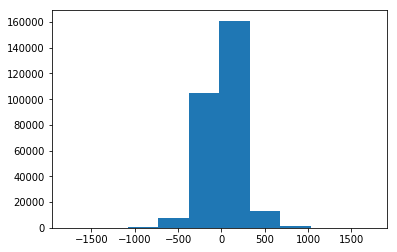

In [13]:
cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
       'rotation_alpha', 'rotation_beta', 'rotation_gamma']
method = 'plt'

col_bins = {}

for col in cols:
    ts_all, b = find_bins([d[2][col] for d in data], method=method)
    col_bins[col] = b

In [14]:
df = create_dataframe(data, cols)

In [15]:
df.iloc[0]

ACCELERATION_X_binfrac_0                     0
ACCELERATION_X_binfrac_1                     0
ACCELERATION_X_binfrac_2                     0
ACCELERATION_X_binfrac_3                     0
ACCELERATION_X_binfrac_4               0.22884
ACCELERATION_X_binfrac_5              0.761755
ACCELERATION_X_binfrac_6            0.00940439
ACCELERATION_X_binfrac_7                     0
ACCELERATION_X_binfrac_8                     0
ACCELERATION_X_binfrac_9                     0
ACCELERATION_X_kurtosis               0.184926
ACCELERATION_X_length                      319
ACCELERATION_X_mean_over_median        3.48315
ACCELERATION_X_std_over_median        -27.2695
ACCELERATION_Y_binfrac_0                     0
ACCELERATION_Y_binfrac_1                     0
ACCELERATION_Y_binfrac_2                     0
ACCELERATION_Y_binfrac_3                     0
ACCELERATION_Y_binfrac_4              0.990596
ACCELERATION_Y_binfrac_5            0.00940439
ACCELERATION_Y_binfrac_6                     0
ACCELERATION_

In [16]:
df = df[~df['label'].isin(['draw-triangle'])]
df['label'].value_counts()

draw-cross     185
roll           137
shake          136
fever          123
draw-circle    121
floss          110
Name: label, dtype: int64

In [17]:
np.random.seed(0)

train_df, test_df = train_test_split(df, train_size=0.70)

/home/macermak/.local/share/virtualenvs/2019-demo4-ai-FZCiEg3v/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (568, 86)
test size = (244, 86)
draw-cross     131
shake          103
fever           91
draw-circle     84
roll            82
floss           77
Name: label, dtype: int64
roll           55
draw-cross     54
draw-circle    37
floss          33
shake          33
fever          32
Name: label, dtype: int64


In [19]:
def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()

    labels = np.sort(list(train_labels.value_counts().index))

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

In [20]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [21]:
model = keras.Sequential([
    keras.layers.Dense(30, activation=tf.nn.sigmoid, input_shape=(85,)),
    keras.layers.Dropout(0.05, seed=42),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
optimizer = keras.optimizers.Adam(lr=1e-3)
loss      = tf.nn.softmax_cross_entropy_with_logits_v2
metrics   = ['accuracy']

model.compile(optimizer=optimizer,  loss=loss, metrics=metrics)

In [23]:
history = model.fit( train_df.drop('label', axis=1), train_onehot, epochs=15, steps_per_epoch=200, verbose=1)

Epoch 1/15
200/200 [==============================] - 1s 3ms/step - loss: 1.2183 - acc: 0.6150
Epoch 2/15
200/200 [==============================] - 1s 3ms/step - loss: 0.7586 - acc: 0.8752
Epoch 3/15
200/200 [==============================] - 1s 3ms/step - loss: 0.5390 - acc: 0.9172
Epoch 4/15
200/200 [==============================] - 1s 3ms/step - loss: 0.4089 - acc: 0.9364
Epoch 5/15
200/200 [==============================] - 1s 3ms/step - loss: 0.3390 - acc: 0.9401
Epoch 6/15
200/200 [==============================] - 1s 5ms/step - loss: 0.2968 - acc: 0.9416
Epoch 7/15
200/200 [==============================] - 1s 4ms/step - loss: 0.2615 - acc: 0.9455
Epoch 8/15
200/200 [==============================] - 1s 3ms/step - loss: 0.2273 - acc: 0.9478
Epoch 9/15
200/200 [==============================] - 1s 3ms/step - loss: 0.2072 - acc: 0.9545
Epoch 10/15
200/200 [==============================] - 1s 3ms/step - loss: 0.1910 - acc: 0.9587
Epoch 11/15
200/200 [============================

In [24]:
test_loss, test_acc = model.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

244/244 [==============================] - 0s 708us/sample - loss: 0.4797 - acc: 0.9016
Test accuracy: 0.90163934


Text(0, 0.5, 'predicted')

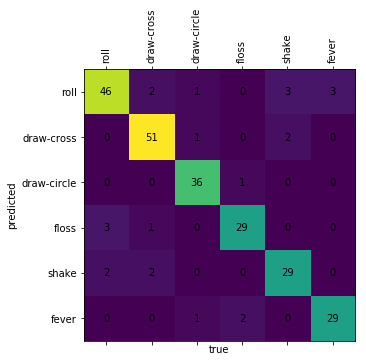

In [25]:
y_hat = model.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [26]:
print(classification_report(test_label, y_hat, labels=labels))

              precision    recall  f1-score   support

        roll       0.90      0.84      0.87        55
  draw-cross       0.91      0.94      0.93        54
 draw-circle       0.92      0.97      0.95        37
       floss       0.91      0.88      0.89        33
       shake       0.85      0.88      0.87        33
       fever       0.91      0.91      0.91        32

   micro avg       0.90      0.90      0.90       244
   macro avg       0.90      0.90      0.90       244
weighted avg       0.90      0.90      0.90       244



In [27]:
save = True
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/v4/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}

rm: cannot remove 'models/v4/pb/1554746791': No such file or directory
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/v4/pb/1554746791/saved_model.pb

Saved model:
total 140
-rw-r--r--. 1 macermak vpnusers 139114 Apr  8 20:06 saved_model.pb
drwxr-xr-x. 2 macermak vpnusers   4096 Apr  8 20:06 variables

Saved model:
total 56
-rw-r--r--. 1 macermak vpnusers 57240 Apr  8 20:06 saved_model.h5

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.

Save

---

### Knative

In [ ]:
%%bash

oc start-build tf-serving --from-dir .

In [ ]:
builds = !oc get builds
latest = builds[-1].split()[0]

!oc logs -f build.build.openshift.io/$latest

In [ ]:
revision = int(dt.timestamp(dt.now()))

!oc process tf-serving-knative -p REVISION=$revision | oc apply -f -

In [ ]:
%%bash

while oc get pods | grep tf-serving-knative | grep -v Running; do 
    oc get pods | grep tf-serving-knative
    sleep 1
done

In [ ]:
%%bash --out KSERVICE_DOMAIN

oc get kservice tf-serving-knative-demo -o jsonpath='{.status.domain}'

In [ ]:
KSERVICE_DOMAIN

In [ ]:
import requests

INGRESS_GATEWAY="istio-ingressgateway.istio-system.svc.cluster.local"

data = {
  "instances": [
    [
      0.625899,
      0.23741,
      0.035971,
      0.035971,
      0.028777,
      0.014388,
      0.021583,
      0,
      0,
      4.7488,
      139,
      1.359591,
      1.667831
    ]
  ],
  "signature": "serving_default"
}

json_response = requests.post("http://%s/model/predict" % INGRESS_GATEWAY, json=data, headers={"Host": KSERVICE_DOMAIN, "Content-Type":"application/json"})
json_response.content